In [13]:
from h3 import h3
import requests
import folium
import pandas as pd
import geopandas as gpd

from shapely.geometry import Polygon
from shapely.geometry import Point

In [46]:
## Lets get boundary of Kolkata city from OSM and plot it
search_string = 'Delhi'
urlData = requests.get(f'https://nominatim.openstreetmap.org/search.php?q={search_string}&polygon_geojson=1&format=json').json()
bounds = pd.DataFrame.from_dict(urlData)
bounds.head()

,place_id,licence,osm_type,osm_id,boundingbox,lat,lon,display_name,class,type,importance,icon,geojson
0,25448708,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,2702400314,"[28.4917178, 28.8117178, 77.0619388, 77.3819388]",28.6517178,77.2219388,"Delhi, Kotwali Tehsil, Central Delhi, Delhi, 1...",place,city,0.770289,https://nominatim.openstreetmap.org/ui/mapicon...,"{'type': 'Point', 'coordinates': [77.2219388, ..."
1,338166806,"Data © OpenStreetMap contributors, ODbL 1.0. h...",relation,1942586,"[28.4046285, 28.8834464, 76.8388351, 77.346601]",28.6273928,77.1716954,"Delhi, India",boundary,administrative,0.770289,https://nominatim.openstreetmap.org/ui/mapicon...,"{'type': 'Polygon', 'coordinates': [[[76.83883..."
2,297800434,"Data © OpenStreetMap contributors, ODbL 1.0. h...",relation,128565,"[42.4230572, 42.4376091, -91.3406123, -91.3208...",42.4297057,-91.3309112,"Delhi, Delaware County, Iowa, United States",boundary,administrative,0.543165,https://nominatim.openstreetmap.org/ui/mapicon...,"{'type': 'Polygon', 'coordinates': [[[-91.3406..."
3,297537555,"Data © OpenStreetMap contributors, ODbL 1.0. h...",relation,137528,"[44.592216, 44.60357, -95.223451, -95.203144]",44.5991256,-95.211113,"Delhi, Redwood County, Minnesota, United States",boundary,administrative,0.539333,https://nominatim.openstreetmap.org/ui/mapicon...,"{'type': 'Polygon', 'coordinates': [[[-95.2234..."
4,297096817,"Data © OpenStreetMap contributors, ODbL 1.0. h...",relation,176126,"[42.256461, 42.297427, -74.938181, -74.894297]",42.2781401,-74.9159946,"Village of Delhi, Town of Delhi, Delaware Coun...",boundary,administrative,0.510665,https://nominatim.openstreetmap.org/ui/mapicon...,"{'type': 'Polygon', 'coordinates': [[[-74.9381..."


In [21]:
delhib = gpd.GeoDataFrame({'city':'Delhi (India)','geometry' : 
                           Polygon(bounds[(bounds.type == 'administrative') & (bounds.display_name == 'Delhi, India')].geojson.to_dict()[1]['coordinates'][0])}, index=[0])

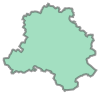

In [44]:
delhib.geometry[0]

In [57]:
m = folium.Map(location=[28.6273928, 77.1716954], zoom_start=10)

bounds_folium = []
for pt in bounds[(bounds.type == 'administrative') & (bounds.display_name == 'Delhi, India')].geojson.to_dict()[1]['coordinates'][0]:
    bounds_folium.append([pt[1],pt[0]])

folium.PolyLine(bounds_folium).add_to(m)
m

In [35]:
hexs = h3.polyfill(
    Polygon(bounds[bounds.type == 'administrative'].head(2).geojson.to_dict()[1]['coordinates'][0]).__geo_interface__, 7, geo_json_conformant = True)

In [36]:
polygonise = lambda hex_id: Polygon(
    h3.h3_to_geo_boundary(
    hex_id, geo_json=True))
all_polys = gpd.GeoSeries(list(map(polygonise, hexs)), \
                          index=hexs, \
                          crs="EPSG:4326")

In [59]:
m = all_polys.reset_index().explore(tiles="CartoDB positron")
folium.PolyLine(bounds_folium, color='black').add_to(m)
m